In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
np.random.seed(4)
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# path for training data and validation data
train = "data/train"
validation = "data/validation"
test = "data/test/images"

In [ ]:
# check size of the dataset
train_food = os.listdir(train+'/food/')
train_nonfood = os.listdir(train+'/nonfood/')

val_food = os.listdir(validation+'/food/')
val_nonfood = os.listdir(validation+'/nonfood/')

test_all = os.listdir(test)

print("Train Food category size {}".format(len(train_food)))
print("Train Non Food category size {}".format(len(train_nonfood)))
print("Validation Food category size {}".format(len(val_food)))
print("Validation Non Food category size {}".format(len(val_nonfood)))
print("Test Food category size {}".format(len(test_all)))

Train Food category size 1500
Train Non Food category size 1500
Validation Food category size 500
Validation Non Food category size 500
Test Food category size 1000


In [ ]:
def plot_image(path):
    filenames = os.listdir(path)
    sample_idx = np.random.choice(filenames,3)
    fig, axs = plt.subplots(1, 3,figsize=(15, 15))
    pos = 0
    for col in range(3):
        filepath= path + "/"+sample_idx[pos]
        axs[col].imshow(image.load_img(filepath))
        pos = pos + 1
    return

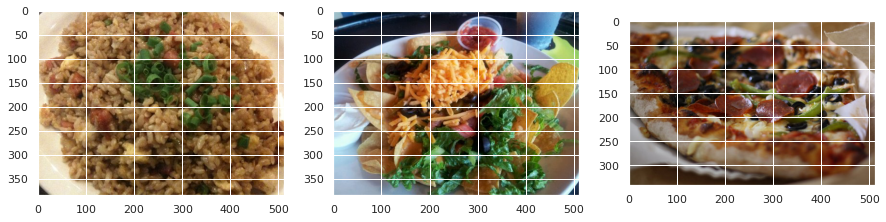

In [ ]:
plot_image(train+'/food/')

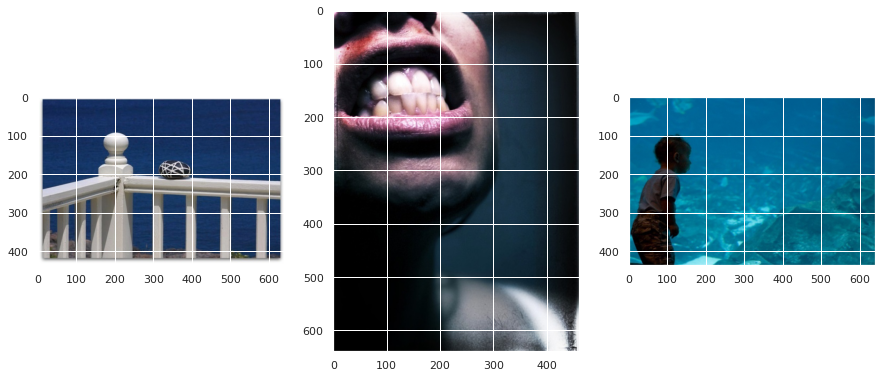

In [ ]:
plot_image(train+'/nonfood/')

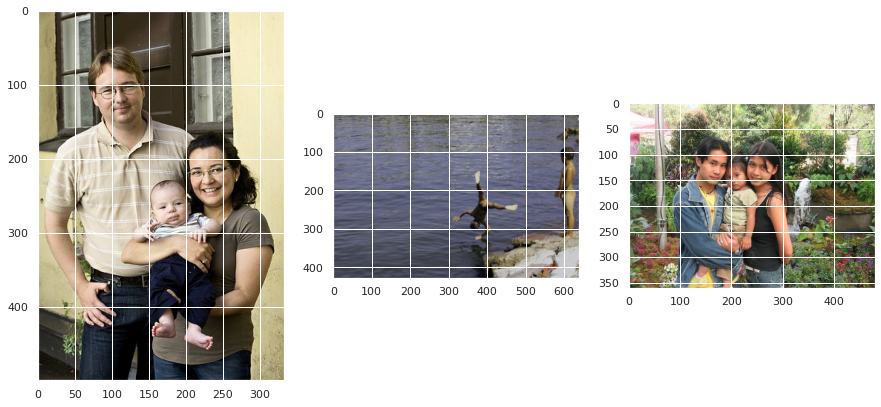

In [ ]:
plot_image(validation+'/nonfood/')

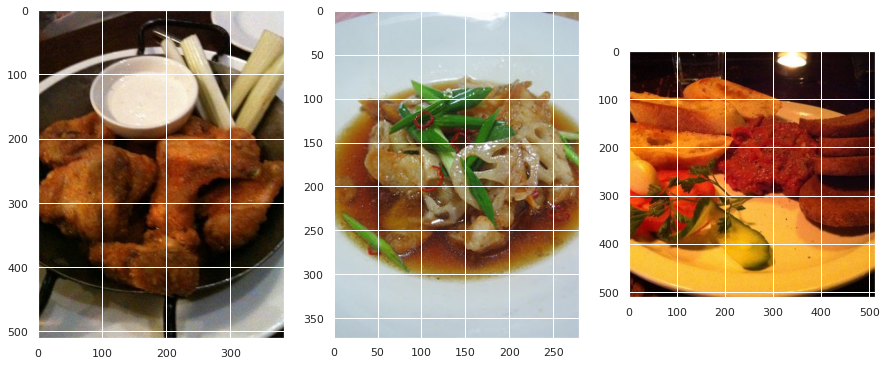

In [ ]:
plot_image(validation+'/food/')

In [ ]:
# define parameters
image_size = (124,124,3)
batch_size = 128


# create image data generator
train_data_gen = ImageDataGenerator(rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,
                                    shear_range=0.1,zoom_range=0.2,horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

valid_data_gen = ImageDataGenerator(rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,
                                    shear_range=0.1,zoom_range=0.2,horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

# create image generator
train_generator = train_data_gen.flow_from_directory(train,shuffle=True,target_size=image_size[:-1],
                                                     batch_size=batch_size)
valid_generator = train_data_gen.flow_from_directory(validation,shuffle=True,target_size=image_size[:-1],
                                                     batch_size=batch_size)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# download pre trained model VGG 16
trained_model = VGG16(input_shape=image_size,weights='imagenet',include_top=False)

# free layers of pre trained model
trained_model.trainable = False

In [ ]:
trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 124, 124, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 124, 124, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 124, 124, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0     

In [ ]:
# no of output nodes
n_output = len(os.listdir(train))

# build model
x = Flatten()(trained_model.output)

# output layer
x = Dense(n_output,activation='softmax')(x)

# create model
model = Model(trained_model.input,x)

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# compute steps size as generator can run for indefinetly
train_steps = int((len(train_food)+len(train_nonfood))/batch_size)
valid_steps = int((len(val_food)+len(val_nonfood))/batch_size)

# train the model
hist = model.fit_generator(train_generator,validation_data=valid_generator, epochs=10,
                           steps_per_epoch=train_steps,validation_steps=valid_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
23/23 [==============================] - 32s 1s/step - loss: 2.1098 - accuracy: 0.8632 - val_loss: 1.0957 - val_accuracy: 0.9397
Epoch 2/10
23/23 [==============================] - 31s 1s/step - loss: 0.8532 - accuracy: 0.9502 - val_loss: 0.8318 - val_accuracy: 0.9509
Epoch 3/10
23/23 [==============================] - 32s 1s/step - loss: 0.5703 - accuracy: 0.9624 - val_loss: 0.9124 - val_accuracy: 0.9520
Epoch 4/10
23/23 [==============================] - 32s 1s/step - loss: 0.5775 - accuracy: 0.9638 - val_loss: 1.0725 - val_accuracy: 0.9408
Epoch 5/10
23/23 [==============================] - 31s 1s/step - loss: 0.4474 - accuracy: 0.9610 - val_loss: 0.8912 - val_accuracy: 0.9498
Epoch 6/10
23/23 [==============================] - 32s 1s/step - loss: 0.3762 - accuracy: 0.9704 - val_loss: 0.7948 - val_accuracy: 0.9587
Epoch 7/10
23/23 [==============================] - 32s 1s/step - loss: 0.3264 - acc

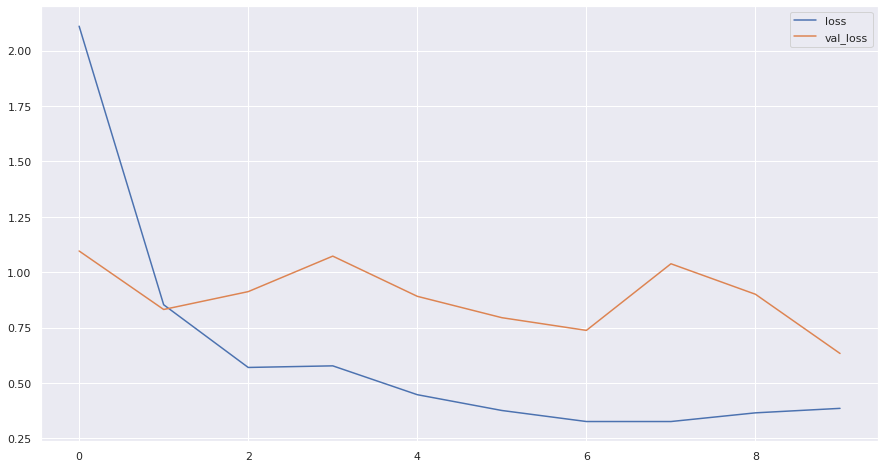

In [ ]:
# plot loss 
plt.figure(figsize=(15,8))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

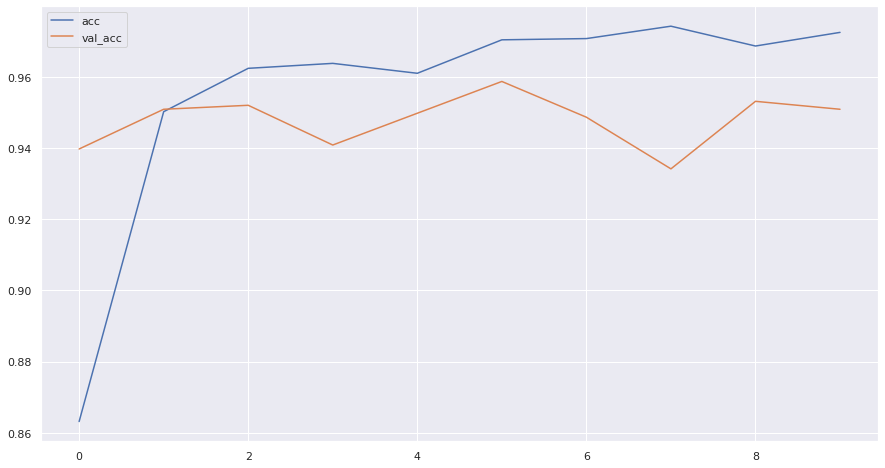

In [ ]:
# Plot  accuracy 
plt.figure(figsize=(15,8))
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
# data gen
test_folder = 'data/test'

test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# create image generator
test_generator = test_data_gen.flow_from_directory(test_folder,shuffle=False,target_size=image_size[:-1],
                                                    batch_size=len(test_all))

Found 1000 images belonging to 1 classes.


In [ ]:
predict = model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
df = pd.DataFrame(predict.argmax(axis = 1),columns=['predict'])
cat_map = {v: k for k, v in train_generator.class_indices.items()}
df['predict'] = df['predict'].map(cat_map)
df['filenames'] = test_generator.filenames
df.sample(4)

,predict,filenames
484,nonfood,images/0_85.jpg
346,nonfood,images/0_41.jpg
734,food,images/1_309.jpg
751,food,images/1_324.jpg


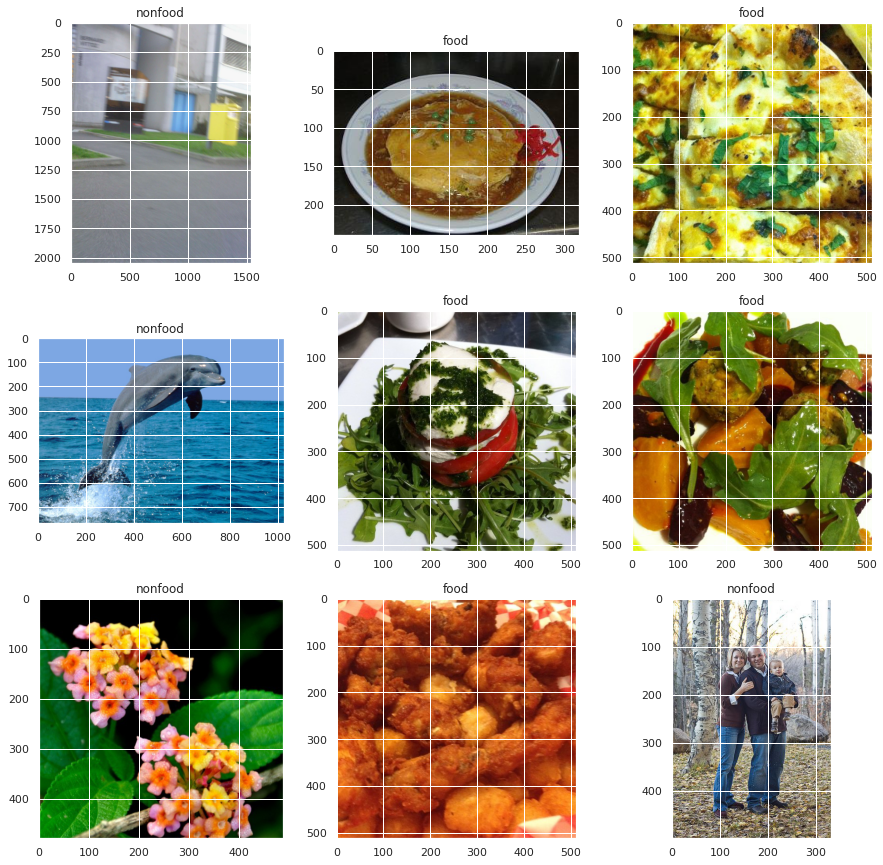

In [ ]:
sample = df.sample(9)
filename = sample['filenames'].tolist()
label = sample['predict'].tolist()
fig, axs = plt.subplots(3, 3,figsize=(15, 15))
pos = 0
for row in range(3):
  for col in range(3):
      filepath= test_folder + "/"+filename[pos]
      axs[row,col].imshow(image.load_img(filepath))
      axs[row,col].set_title(label[pos])
      pos = pos + 1